In [1]:
#libraries
import pandas as pd #датафреймы
import numpy as np #массивы, линейная алгебра
import pylab as pl #графики
import math
import matplotlib as mpl #графики
%matplotlib inline
%pylab inline
import datetime
import seaborn as sns #красивые графики!
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
#scripts
#read date
def prepare_data(path):
    df=pd.read_csv(path, index_col=False, header =0)
    df.Second=df.Second.astype(int)
    for i in df.loc[df.Second==60].index:
        df.loc[i,'Second']=59
    df.string=df.Year.astype(str) + '-' + df.Month.astype(str) + '-' + df.Day.astype(str) + \
        ' ' + df.Hour.astype(str) + ':' + df.Minute.astype(str) + ':' + df.Second.astype(str)
    df['Date']=pd.to_datetime(df.string)
    df['t']=df['Date'].diff().fillna(0)
    df['logtime']=df.t / np.timedelta64(1, 's')
    for i in df.loc[df.logtime==0].index:
        df.loc[i,'logtime']=1.0
    df.logtime=df.logtime.apply(lambda x: math.log(x))
    return df
#build distribution
def frameEDF(sample,numbin, edge1, edge2):
    num=numbin
    F=[0 for i in range(num)]
    width=(edge2-edge1)/(num-1)
    xedges=[edge1+(i)*width for i in range(num)]
    for i in range(num):
        F[i]=len(sample.loc[sample <= xedges[i]])/float(len(sample))
    return xedges,F,width
#calculate distances
def distance(xedges1,F1,xedges2,F2):
    F=[0 for i in range(len(F1))]
    for i in range(len(F1)):
        F[i]=abs(F1[i]-F2[i])
    return max(F)
#plot distances
def distanceplot(sample,window,bins):
    length=len(sample)-2*window
    dist=[0 for i in range(length)]
    for i in range(length):
        edge1=sample[i:i+2*window].min()
        edge2=sample[i:i+2*window].max()
        xedges1,F1,width1=frameEDF(sample[i:i+window],bins,edge1,edge2)
        xedges2,F2,width2=frameEDF(sample[i+window:i+2*window],bins,edge1,edge2)
        dist[i]=distance(xedges1,F1,xedges2,F2)
    return dist
#calculate float EDF
def shiftEDFplot(sample, win, bins):
    num = len(sample)-win
    xedges=[0 for i in range(num)]
    yedges = [[0 for i in range(bins+1)] for j in range(num)]
    F=[0 for i in range(num)]
    width=[0 for i in range(num)]
    for i in range(num):
        xedges[i],F[i],width[i]=frameEDF(sample[i:i+win],bins,sample[i:i+win].min(),sample[i:i+win].max())
        yedges[i]=[i for j in range(len(xedges[i]))]
    xpos=np.array(xedges[0])
    ypos=np.array(yedges[0])
    zpos=np.array(F[0])
    for i in range(1,len(xedges)):
        xpos=np.append(xpos,xedges[i])
        ypos=np.append(ypos,yedges[i])
        zpos=np.append(zpos,F[i])
    return xpos,ypos,zpos
#plot float EDF
def distribution_plot(sample):
    xpos,ypos,zpos=shiftEDFplot(sample,100,15)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(xpos, ypos, zpos,cmap=plt.cm.jet,linewidth=0)
    ax.view_init(elev=25., azim=115)
#calculate stationarity index
def stat_index(sample, window,bins):
    kolm_index=0.18+(window-100)*(-0.04)/100.
    print "window = ", window
    print "epsilon = ", kolm_index
    ar = pd.Series.from_array(distanceplot(sample,window,window))
    xedges,F,width=frameEDF(ar,bins, ar.min(),ar.max())
    plt.bar(xedges,F,width)
    x = np.linspace(0, ar.max(), bins)
    y = 1 - x
    plt.plot(x,y,'-')
    for i in range(len(xedges)):
        if((1-xedges[i])<F[i]):
            #print xedges[i]
            print "Stationarity index = ", (xedges[i])/kolm_index
            break
#            return (xedges[i])/kolm_index
def times(sample,frame):
    deltas = list(sample / np.timedelta64(1, 's'))
    array = [0 for i in range(len(sample)-frame+1)]
    for i in range(len(sample)-frame+1):
        for j in range(frame):
            array[i]+=deltas[i+j]
    return array

In [3]:
path = 'OUT_1.csv'
df = prepare_data(path)

Depth


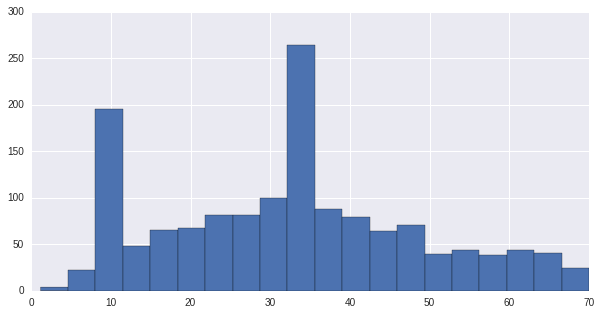

In [4]:
print "Depth"
df.Depth.hist(figsize=(10,5), bins=20)

Magnitude


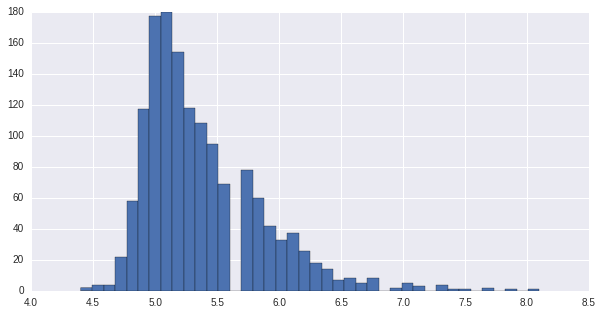

In [5]:
print "Magnitude"
df.Magnitude.hist(figsize=(10,5), bins=40)

Log.time


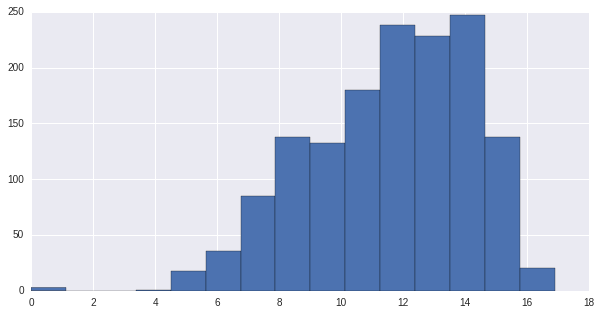

In [6]:
print "Log.time"
df.logtime.hist(figsize=(10,5), bins=15)

Depth and magnitude joint plot


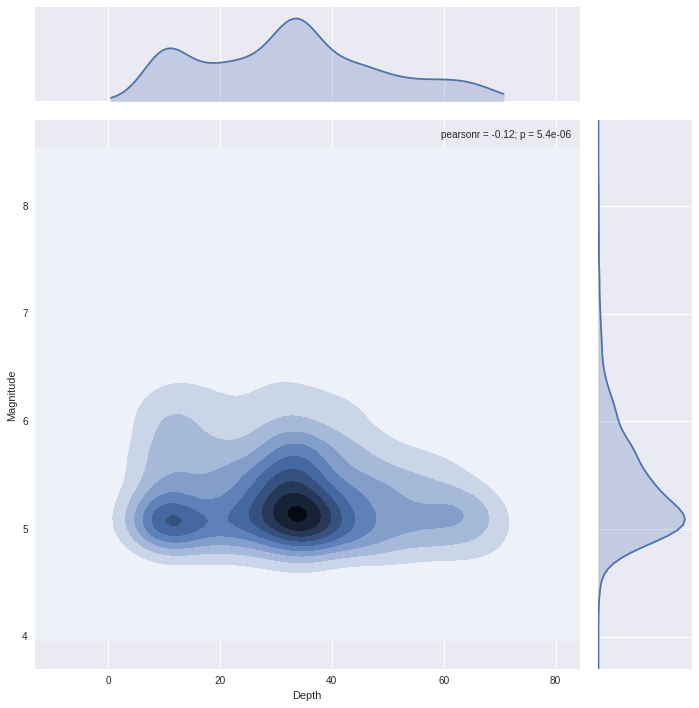

In [7]:
print "Depth and magnitude joint plot"
sns.jointplot(x='Depth', y='Magnitude', data=df, size=10,kind='kde');

Depth and logtime joint plot


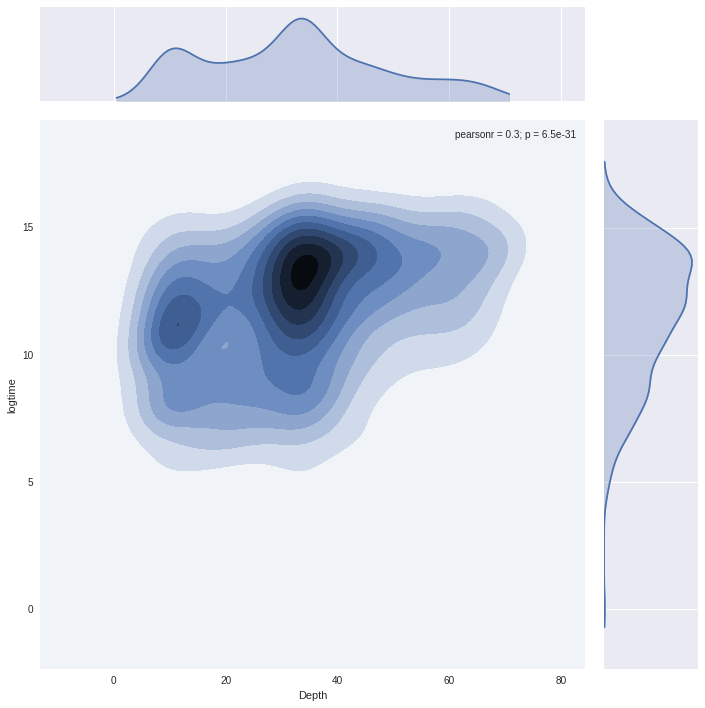

In [8]:
print "Depth and logtime joint plot"
sns.jointplot(x='Depth', y='logtime', data=df, size=10,kind='kde');

Magnitude and logtime joint plot


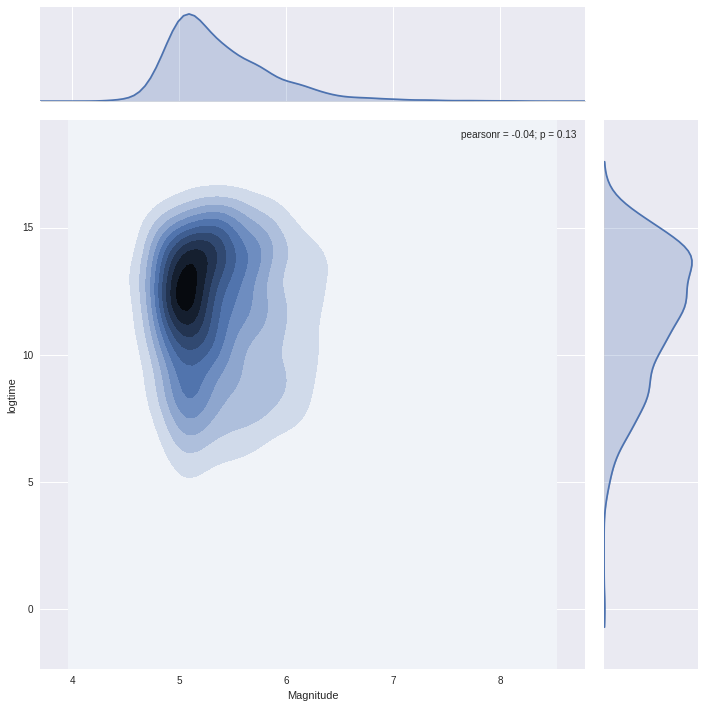

In [9]:
print "Magnitude and logtime joint plot"
sns.jointplot(x='Magnitude', y='logtime', data=df, size=10,kind='kde');

Depth float distribution, window = 100


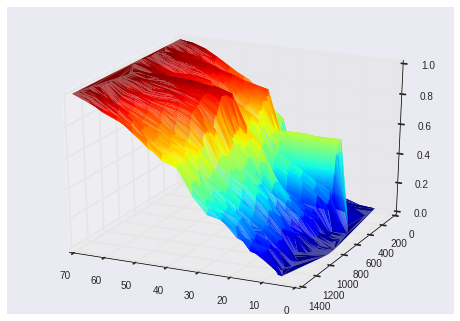

In [10]:
print "Depth float distribution, window = 100"
distribution_plot(df.Depth)

Magnitude float distribution, window = 100


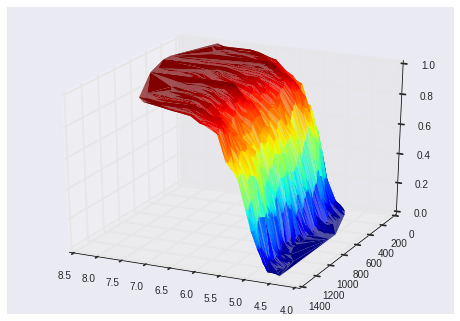

In [11]:
print "Magnitude float distribution, window = 100"
distribution_plot(df.Magnitude)

Logtime float distribution, window = 100


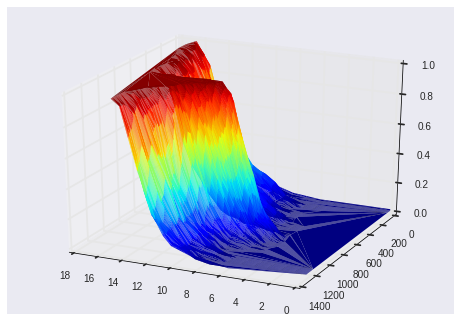

In [12]:
print "Logtime float distribution, window = 100"
distribution_plot(df.logtime)

Float distances between depth distibutions, window = 100


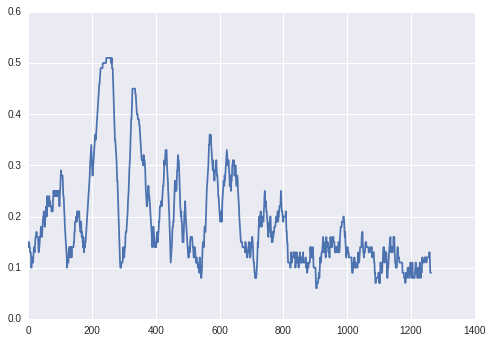

In [13]:
print "Float distances between depth distibutions, window = 100"
plt.plot(distanceplot(df.Depth,100,100))

Float distances between magnitude distibutions, window = 100


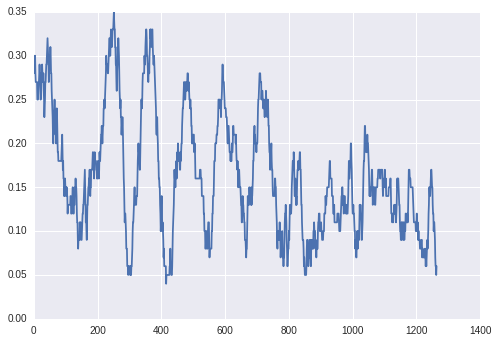

In [14]:
print "Float distances between magnitude distibutions, window = 100"
plt.plot(distanceplot(df.Magnitude,100,100))

Float distances between logtime distibution, window = 100


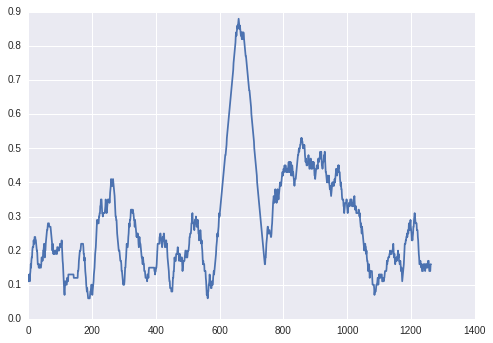

In [15]:
print "Float distances between logtime distibution, window = 100"
plt.plot(distanceplot(df.logtime,100,100))

In [16]:
frame=100

Depth stationarity index
window =  100
epsilon =  0.18
Stationarity index =  1.34343434343


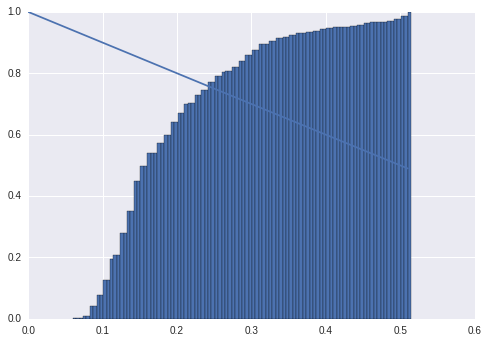

In [17]:
print "Depth stationarity index"
stat_index(df.Depth,frame,frame)

Magnitude stationarity index
window =  100
epsilon =  0.18
Stationarity index =  1.23120089787


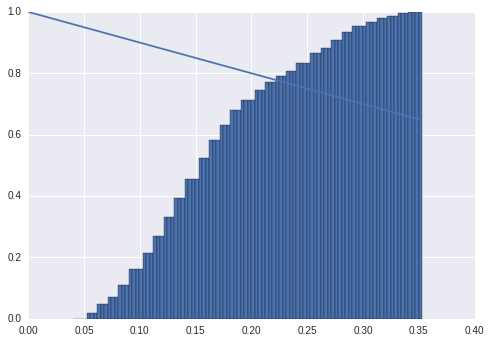

In [18]:
print "Magnitude stationarity index"
stat_index(df.Magnitude,frame,frame)

Logtime stationarity index
window =  100
epsilon =  0.18
Stationarity index =  1.85185185185


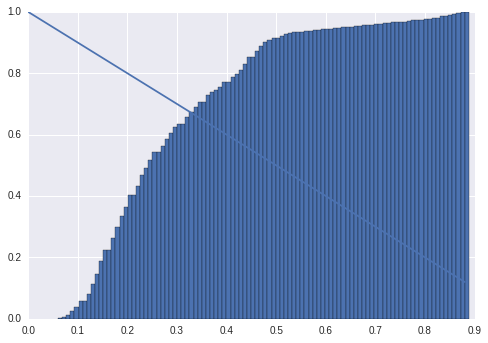

In [19]:
print "Logtime stationarity index"
stat_index(df.logtime,frame,frame)

In [20]:
frame=150

Depth stationarity index
window =  150
epsilon =  0.16
Stationarity index =  1.50279642058


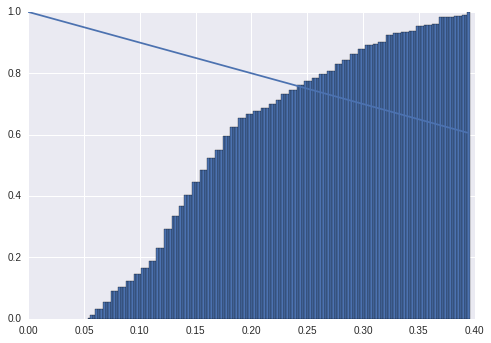

In [21]:
print "Depth stationarity index"
stat_index(df.Depth,frame,frame)

Magnitude stationarity index
window =  150
epsilon =  0.16
Stationarity index =  1.25419463087


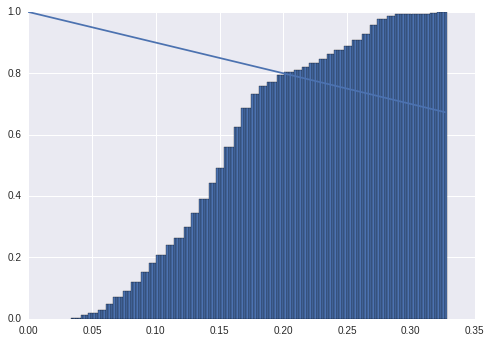

In [22]:
print "Magnitude stationarity index"
stat_index(df.Magnitude,frame,frame)

Logtime stationarity index
window =  150
epsilon =  0.16
Stationarity index =  2.20973154362


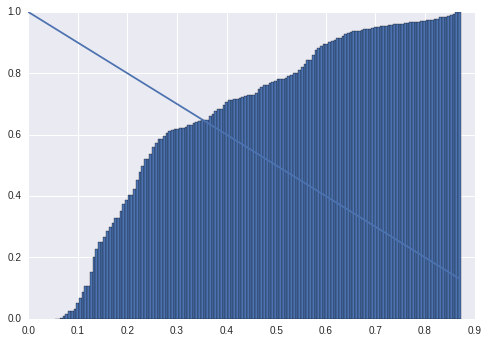

In [23]:
print "Logtime stationarity index"
stat_index(df.logtime,frame,frame)

In [24]:
frame=200

Depth stationarity index
window =  200
epsilon =  0.14
Stationarity index =  1.73295046662


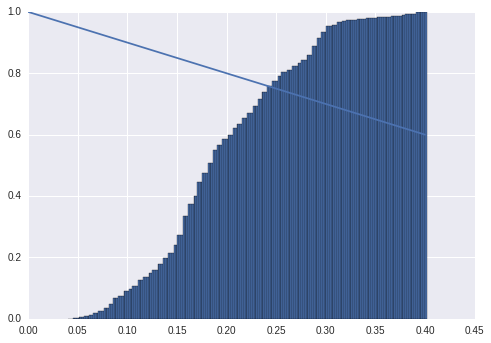

In [25]:
print "Depth stationarity index"
stat_index(df.Depth,frame,frame)

Magnitude stationarity index
window =  200
epsilon =  0.14
Stationarity index =  1.46518305815


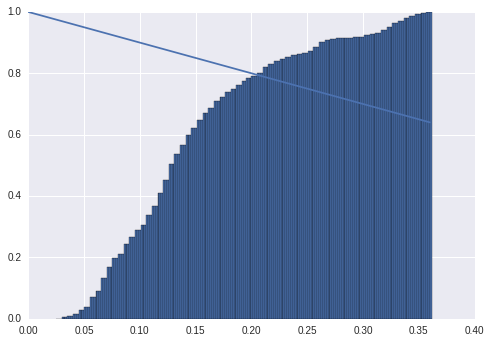

In [26]:
print "Magnitude stationarity index"
stat_index(df.Magnitude,frame,frame)

Logtime stationarity index
window =  200
epsilon =  0.14
Stationarity index =  2.85050251256


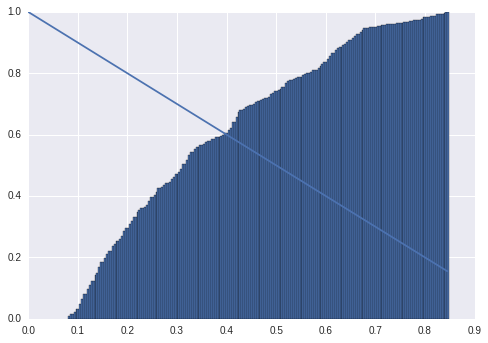

In [27]:
print "Logtime stationarity index"
stat_index(df.logtime,frame,frame)

In [28]:
frame=250

Depth stationarity index
window =  250
epsilon =  0.12
Stationarity index =  1.80562248996


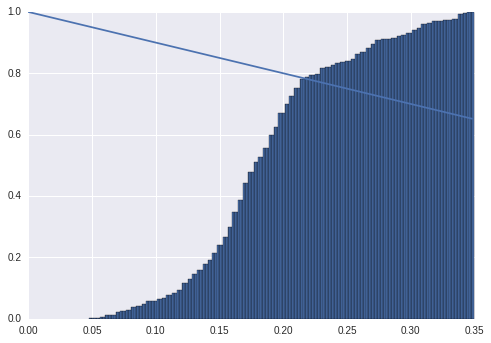

In [29]:
print "Depth stationarity index"
stat_index(df.Depth,frame,frame)

Magnitude stationarity index
window =  250
epsilon =  0.12
Stationarity index =  1.7


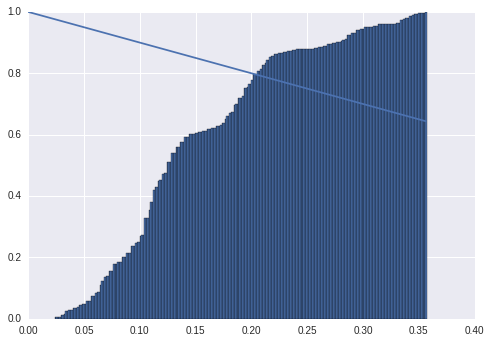

In [30]:
print "Magnitude stationarity index"
stat_index(df.Magnitude,frame,frame)

Logtime stationarity index
window =  250
epsilon =  0.12
Stationarity index =  3.57563587684


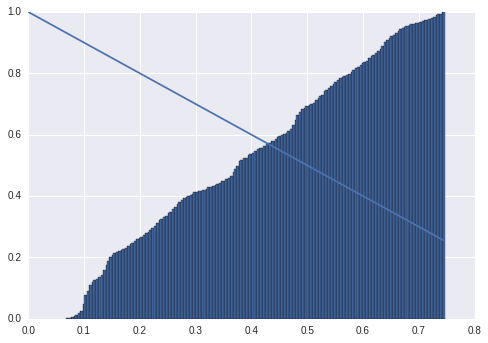

In [31]:
print "Logtime stationarity index"
stat_index(df.logtime,frame,frame)

mean 78046295.4842


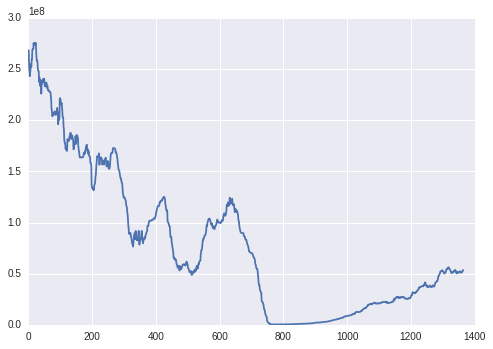

In [32]:
frame=100
print "mean", mean(times(df.t,frame))
plt.plot(times(df.t,frame))

mean 112799085.051


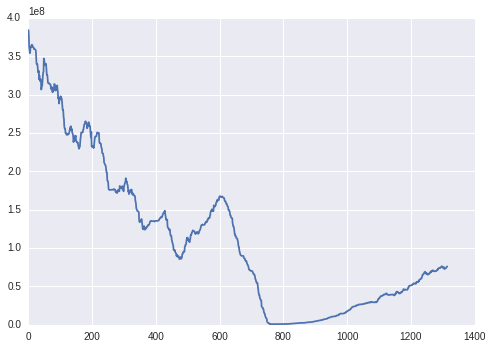

In [33]:
frame=150
print "mean", mean(times(df.t,frame))
plt.plot(times(df.t,frame))